In [1]:
from faiss import IndexFlatIP, IndexFlat
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import tqdm
import pandas

In [2]:
!pip install git+https://github.com/cat-state/clip_benchmark

  Cloning https://github.com/cat-state/clip_benchmark to /tmp/pip-req-build-hno8lnh9
  Running command git clone --filter=blob:none --quiet https://github.com/cat-state/clip_benchmark /tmp/pip-req-build-hno8lnh9
  Resolved https://github.com/cat-state/clip_benchmark to commit 0e9180ad09e1e96d55d75ef30d11c08e98122219
  Preparing metadata (setup.py) ... done


In [3]:
!git lfs install
!git clone https://huggingface.co/datasets/cat-state/clip-embeddings || true

Updated Git hooks.
Git LFS initialized.
fatal: destination path 'clip-embeddings' already exists and is not an empty directory.


In [15]:
# The following models form two sets of comparable models. The big models are trained on LAION-400M and the small models are trained on ????.
# All models are evaluated on MS COCO

models = {
    "CLIP_big": {
        "name": "CLIP ViT-B/16",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/coco-embeds-open-clip-vit-b-16/img_emb/img_emb_0.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/coco-embeds-open-clip-vit-b-16/text_emb/text_emb_0.npy"
        ),
    },
    "CLOOB_big": {
        "name": "CLOOB ViT-B/16",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy"
        ),
    },
    "CLIP_big_laion": {
        "name": "CLIP ViT-B/16 evaluated on LAION",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/laion-embeds-open-clip-vit-b-16/img_emb/img_emb_0.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/laion-embeds-open-clip-vit-b-16/text_emb/text_emb_0.npy"
        ),

    },
    "CLOOB_big_laion": {
        "name": "CLOOB ViT-B/16 evaluated on LAION",
        "img_embeds": np.lib.format.open_memmap(
            "laion-embeds-cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_laion2B-en-5k_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "laion-embeds-cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_laion2B-en-5k_text_embeds.npy"
        ),

    },
    "CLIP_small_infoNCE": {
        "name": "CLIP RN50",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy"
        ),
    },
    "CLIP_small_infoLOOB": {
        "name": "CLIP RN50 (infoLOOB)",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy"
        ),
    },
    "CLOOB_small_infoNCE": {
        "name": "CLOOB RN50 (infoNCE)",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy"
        ),
    },
    "CLOOB_small_infoLOOB": {
        "name": "CLOOB RN50 (infoLOOB)",
        "img_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"
        ),
        "text_embeds": np.lib.format.open_memmap(
            "clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy"
        ),
    },
}

In [16]:
from clip_benchmark import cross_modal_retrieval

In [17]:
import pandas

subset = 5000

results = []
for key, embeds in tqdm.tqdm(models.items()):
    img_embeds = embeds["img_embeds"][:subset]
    txt_embeds = embeds["text_embeds"][:subset]
    results.append({**cross_modal_retrieval(img_embeds, txt_embeds), "name": embeds["name"]})

results = pandas.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.02s/it]


In [26]:
results["text to img @1"] = results["text->img"].apply(lambda x: x[:, 0].sum() / subset)
results["img to text @1"] = results["img->text"].apply(lambda x: x[:, 0].sum() / subset)
results["text to img @5"] = results["text->img"].apply(lambda x: x[:, :5].any(-1).sum() / subset)
results["img to text @5"] = results["img->text"].apply(lambda x: x[:, :5].any(-1).sum() / subset)

In [27]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

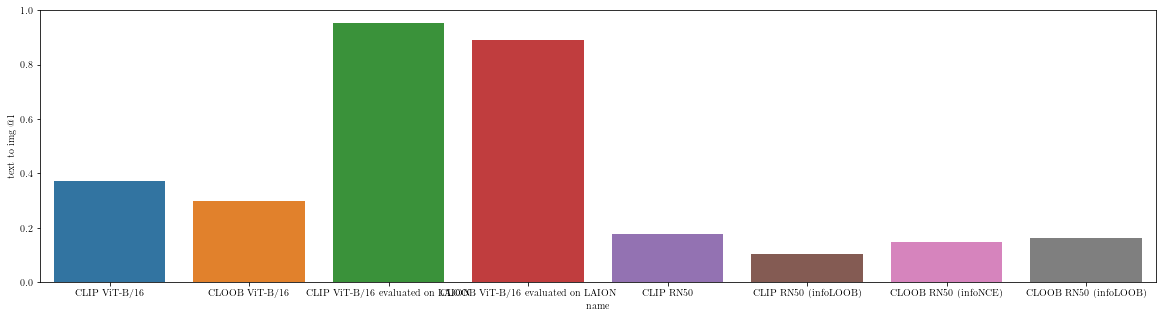

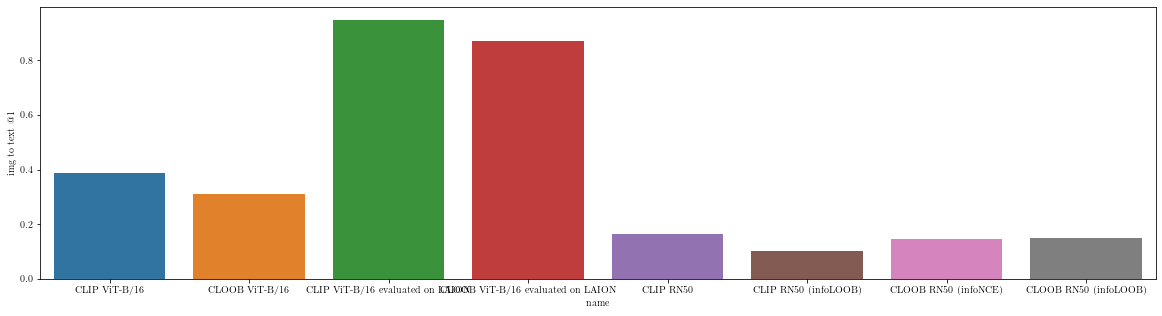

In [28]:
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="text to img @1")
plt.savefig("figures/text->img retrieval @1.png")
plt.show()
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="img to text @1")
plt.savefig("figures/img->text retrieval @1.png")


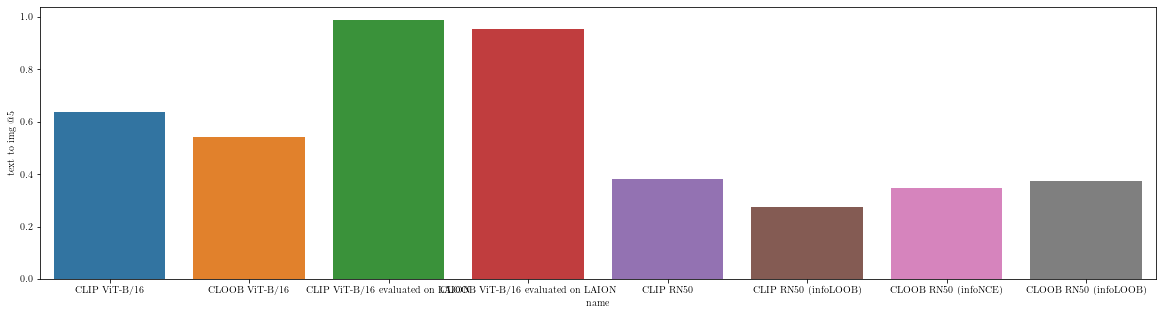

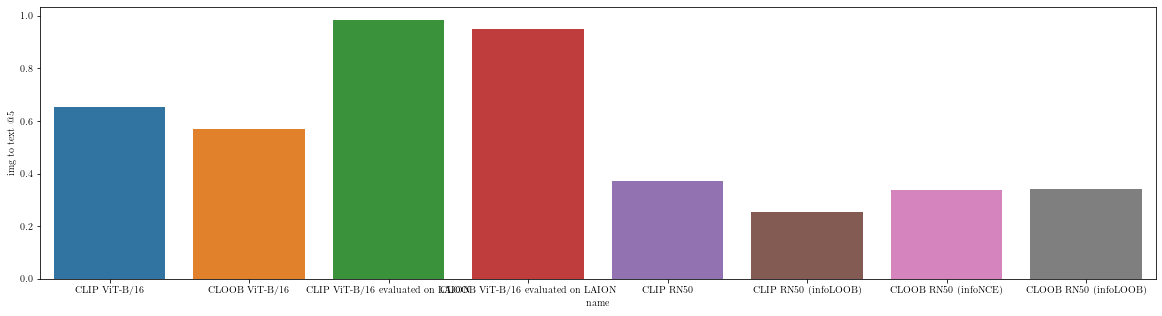

In [29]:
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="text to img @5")
plt.savefig("figures/text->img retrieval @5.png")
plt.show()
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="img to text @5")
plt.savefig("figures/img->text retrieval @5.png")


In [30]:
results[["name", "text to img @1", "img to text @1", "text to img @5", "img to text @5"]]

,name,text to img @1,img to text @1,text to img @5,img to text @5
0,CLIP ViT-B/16,0.3712,0.3872,0.6350,0.6534
1,CLOOB ViT-B/16,0.2964,0.3102,0.5400,0.5682
2,CLIP ViT-B/16 evaluated on LAION,0.9526,0.9472,0.9868,0.9836
3,CLOOB ViT-B/16 evaluated on LAION,0.8888,0.8714,0.9528,0.9500
4,CLIP RN50,0.1780,0.1654,0.3806,0.3718
5,CLIP RN50 (infoLOOB),0.1042,0.1006,0.2758,0.2542
6,CLOOB RN50 (infoNCE),0.1458,0.1456,0.3476,0.3368
7,CLOOB RN50 (infoLOOB),0.1604,0.1490,0.3742,0.3420
